# Deep Q-Learning 

Install dependencies for AI gym to run properly (shouldn't take more than a minute). If running on google cloud or running locally, only need to run once. Colab may require installing everytime the vm shuts down.

In [7]:
# !pip3 install gym pyvirtualdisplay
# !sudo apt-get install -y xvfb python-opengl ffmpeg

In [8]:
# !pip3 install --upgrade setuptools --user
# !pip3 install ez_setup 
# !pip3 install gym[atari] 
# !pip3 install gym[accept-rom-license] 

In [9]:
import torch
print(torch.cuda.is_available())  # Should return True if CUDA is available
print(torch.version.cuda)  # Should print 11.8
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"CUDA device: {device}")  # Expected output: "cuda:0" if GPU is available

True
11.8
CUDA device: cuda


For this assignment we will implement the Deep Q-Learning algorithm with Experience Replay as described in breakthrough paper __"Playing Atari with Deep Reinforcement Learning"__. We will train an agent to play the famous game of __Breakout__.

In [10]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
# import gym
import gymnasium as gym
import ale_py
import pylab
import random
import numpy as np
from collections import deque
from datetime import datetime
from copy import deepcopy
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from utils import *
from model import *
from config import *
from checkpoint import *
import pickle
import os

import matplotlib.pyplot as plt


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
# Function to create metadata for checkpointing puposes
def create_metadata(agent, global_episode, global_frame, eval_rewards, rewards, episodes, last_10_ep_losses, loss_tracker, epsilon, q_stats_hist, qmean_win, qmin_win, qmax_win, beta=None, alpha=None):
    return {
    'global_episode': global_episode,
    'global_frame': global_frame,
    'batch_size': BATCH_SIZE,
    'sch_gamma': scheduler_gamma,
    'sch_step_size': scheduler_step_size,
    'tgt_update_freq': update_target_network_frequency,
    'memory capacity': Memory_capacity,  
    'explore steps': EXPLORE_STEPS, 
    'epsilon_decay_rate': agent.epsilon_decay_rate,
    'sticky_action_prob': sticky_action_prob,
    'eval_rewards': eval_rewards,
    'rewards': rewards,
    'episodes': episodes,
    'last_10_ep_losses': last_10_ep_losses,
    'loss_tracker': loss_tracker,
    'epislon': epsilon,
    'q_stats_hist': q_stats_hist,
    'qmean_win': qmean_win,
    'qmin_win': qmin_win,
    'qmax_win': qmax_win,
    'peralpha': alpha,
    'per_beta': beta,
    'lr': agent.optimizer.get_last_lr(),
    'scheduler_step': agent.scheduler.last_epoch
    }

In [12]:
import sys
import os

class TeeLogger:
    def __init__(self, filepath):
        self.original_stdout = sys.__stdout__  # raw terminal (useful fallback)
        self.ipython_stdout = sys.stdout       # the notebook's visible output
        self.log = open(filepath, "w")

    def write(self, message):
        self.ipython_stdout.write(message)
        self.log.write(message)
        self.flush()

    def flush(self):
        self.ipython_stdout.flush()
        self.log.flush()

    def close(self):
        self.log.close()

## Understanding the environment

Unlike the UIlliniois assigment this code is based on, I will be using the Gymnasium (https://github.com/farama-Foundation/gymnasium) and the Atari Learning Environment (ALE, link here: https://ale.farama.org/), rather than gym, which has been deprecated.  We will still be playing Breakout on Atari.

To replecate BreakoutDeterministic-v4, as a starting point we'll use ALE/Breakout-v5 with frameskip=4, no "sticky actions" (i.e. deterministic actions), and a limited action space of NOOP, FIRE, LEFT, RIGHT.  However we won't be training on FIRE, instead we will ensure FIRE only happens when the game first starts and when a ball/life is lost.

In [13]:
# env = gym.make('BreakoutDeterministic-v4')
env = gym.make('ALE/Breakout-v5', frameskip=4, repeat_action_probability=0.0, full_action_space=False)  # Use equivalent parameters to BreakoutDeterministic-v4
state = env.reset()

#### Test Env Frame Output

(185, 160, 3)
height:  185 width:  160


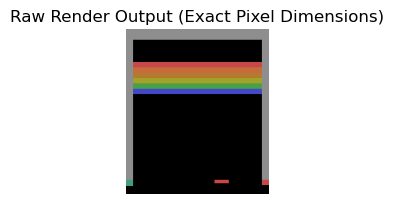

In [14]:
# Create environments
env = gym.make('ALE/Breakout-v5', frameskip=4, repeat_action_probability=sticky_action_prob, full_action_space=False, render_mode="rgb_array")

obs, info = env.reset()
frame = env.render()
frame = frame[20:-5, :, :]

# Calculate figure size in inches to match pixel size
height, width = frame.shape[:2]
print(frame.shape)
print("height: ", height, "width: ", width)
dpi = plt.rcParams['figure.dpi']
figsize = (width / dpi, height / dpi)

# Plot with exact pixel size
plt.figure(figsize=figsize, dpi=dpi)
plt.imshow(frame)
plt.title("Raw Render Output (Exact Pixel Dimensions)")
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()


In [15]:
number_lives = find_max_lives(env)
state_size = env.observation_space.shape
action_size = 3 #noop, left, and right.  Fire ball (action 1) is not trained

## Creating a DQN Agent

Here we create a DQN Agent. This agent is defined in the __agent.py__. The corresponding neural network is defined in the __model.py__. Once you've created a working DQN agent, use the code in agent.py to create a double DQN agent in __agent_double.py__. Set the flag "double_dqn" to True to train the double DQN agent.

__Evaluation Reward__ : The average reward received in the past 100 episodes/games.

__Frame__ : Number of frames processed in total.

__Memory Size__ : The current size of the replay memory.

### Create Replay Memory Pickle

In [ ]:

# # # ### Pickle Replay Creator ###
from gymnasium.wrappers import RecordVideo
from config import *


mem_name = 'CircularPERBuffer_for_testing_using_Run13_orig_get_frame'

#create fresh environment
env = gym.make('ALE/Breakout-v5', frameskip=4, repeat_action_probability=sticky_action_prob, full_action_space=False, render_mode='rgb_array')
# env = RecordVideo(env, video_folder="./videos", episode_trigger=lambda ep: ep % 20 == 0)  

# Choose whether to use double DQN
double_dqn = False # set to True if using double DQN agent
if double_dqn:
    from agent_double import Agent
else:
    from agent import Agent

# print("Instantiating agent")
agent = Agent(action_size)
agent.load_policy_net("./save_model/run13/good_Run13_StdDQN_750K_frames_imprvdBatching_2477_eps.pth")
agent.target_net.load_state_dict(agent.policy_net.state_dict())
agent.epsilon = 0.1

frame = 0   
evaluation_reward = deque(maxlen=evaluation_reward_length)
rewards, episodes = [], []
best_eval_reward = 0
exit_flag = False

for e in range(EPISODES):
    done = False
    score = 0

    history = np.zeros([5, 84, 84], dtype=np.uint8)
    step = 0
    state, _ = env.reset()
    next_state = state
    life = number_lives
    fire_ready = True

    get_init_state(history, state, HISTORY_SIZE)

    while not done:
        step += 1
        frame += 1

        # Selet Action (with robust check for FIRE action)
        if fire_ready:
            next_state, force_done = reset_after_life_loss(env, history)
            if force_done:
                break
            action = 1
            fire_ready = False
        else:
            trainable_action = agent.get_action(np.float32(history[:4, :, :]) / 255.)
            action = TRAINABLE_ACTIONS[trainable_action]

        state = next_state
        next_state, reward, terminations, truncations, info = env.step(action)  
        done = truncations or terminations
        frame_next_state = get_frame(next_state)
        

        history[4, :, :] = frame_next_state
        lost_life = check_live(life, info['lives'])  #check if the agent has lost a life

        if lost_life:
            fire_ready = True

        life = info['lives']
        r = reward

        # Store the transition in memory if it was not a FIRE action
        if action in TRAINABLE_ACTIONS:
            trainable_index = TRAINABLE_ACTIONS.index(action)
            term_state = done or lost_life
            if type(agent.memory).__name__ == "CircularReplayMemoryPER":
                agent.memory.push(agent, deepcopy(frame_next_state), trainable_index, r, term_state)
            else:
                agent.memory.push(deepcopy(frame_next_state), trainable_index, r, term_state)
        # When replay buffer is filled save to pickle and break
        if len(agent.memory) == train_frame:
            print(f"Memory filled, saving pickle file") 
            agent.save_replay_buffer(mem_name, frame)
            exit_flag = True
            break 
        score += reward
        history[:4, :, :] = history[1:, :, :]  # shift history by one erasing oldest frame

        if frame % 500 == 0:
            print("DEBUG: len(valid_flags), len(valid_indices), len(td_errors):", sum(agent.memory.valid_flags), len(agent.memory.valid_indices), len(agent.memory.td_errors))

        if done:
            fire_ready = True
            evaluation_reward.append(score)
            rewards.append(np.mean(evaluation_reward))  # record moving average of last evaluation_reward_length episodes
            episodes.append(e)

            # print episode information 
            if e % 1 == 0:
                print("episode:", e, "  score:", score, "  memory length:",
                  len(agent.memory), "  epsilon:", agent.epsilon, "  steps:", step,
                  "  lr:", agent.optimizer.param_groups[0]['lr'], 
                  "  evaluation reward:", np.mean(evaluation_reward))
    if exit_flag:
        break

In [ ]:
# # Start logging
# log_file = "./test_log.txt"
# tee = TeeLogger(log_file)
# sys.stdout = tee
# sys.stderr = tee

# print(f"Logging started. Output will be written to both notebook and {log_file}")



In [ ]:
# # Stop logging safely
# sys.stdout = tee.original_stdout
# sys.stderr = tee.original_stdout
# tee.close()

# print("This goes only to the notebook now.")

### Main Training Loop

In this training loop, we do not render the screen because it slows down training signficantly. To watch the agent play the game, run the code in next section "Visualize Agent Performance"

In [16]:
## Setup Run Name and Memory Paths ##
mem_path = None
mem_path = './checkpoints/CircularPERBuffer_for_testing_using_Run13_orig_get_frame_50498_replay_buffer.pkl'
# mem_path = './checkpoints/Run1_DQN_Serial_20pctExplore_and_Sticky_100000_replay_buffer.pkl'
# mem_path = './checkpoints/Buffer_for_testing_using_Run5_50K_replay_buffer.pkl'
# mem_path = './checkpoints/Buffer_for_testing_using_Run13_new_get_frame_100974_replay_buffer.pkl'
seed = 84

In [ ]:
# log_dir = f"./logs/run{run_num}"
# os.makedirs(log_dir, exist_ok=True)
# log_file = os.path.join(log_dir, f"{run_name}_output.log")
# tee = TeeLogger(log_file)
# sys.stdout = tee
# sys.stderr = tee

# print(f"Logging started. Output will be written to both notebook and {log_file}")

Starting run Run18_Bootstrapped_run17_stickyactions5percent
Instantiating agent


C:\Users\rbisk\AppData\Local\Temp\ipykernel_369616\1804954441.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('./checkpoints/Run17_StdDQN_750Kfr

Replay buffer loaded from './checkpoints/Run17_StdDQN_750Kfr_newest_get_frame_CirularPER_wIS_159356_replay_buffer.pkl' with size 204356
[SANITIZER] Fixing 0 invalid or nonpositive TD-errors...
Starting training
episode: 1   frame: 120   score: 0.0   memory length: 204471   epsilon: 0.99977   steps: 120   lr: 0.0005   PER_beta: 0.4001 PER Alpha: 0.5999   reward MA: 0.0   mean loss: 0   mean max Q: 2.2937
episode: 2   frame: 268   score: 1.0   memory length: 204614   epsilon: 0.99949   steps: 148   lr: 0.0005   PER_beta: 0.40021 PER Alpha: 0.59979   reward MA: 0.5   mean loss: 0.47062   mean max Q: 1.2021
episode: 3   frame: 416   score: 1.0   memory length: 204757   epsilon: 0.99921   steps: 148   lr: 0.0005   PER_beta: 0.40033 PER Alpha: 0.59967   reward MA: 0.667   mean loss: 0.01387   mean max Q: 1.271
episode: 4   frame: 684   score: 4.0   memory length: 205020   epsilon: 0.9987   steps: 268   lr: 0.0005   PER_beta: 0.40055 PER Alpha: 0.59945   reward MA: 1.5   mean loss: 0.00683   

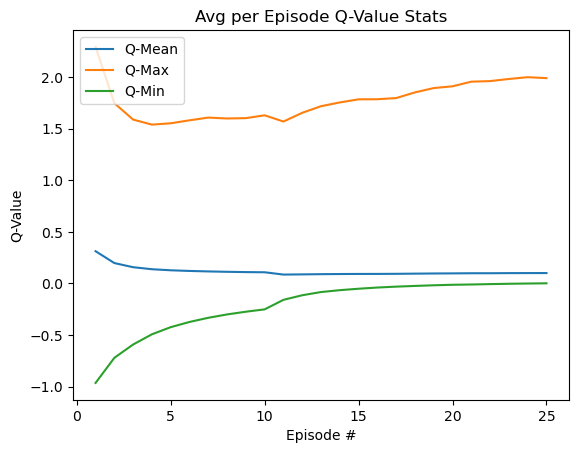

episode: 26   frame: 4128   score: 0.0   memory length: 208354   epsilon: 0.99216   steps: 120   lr: 0.0005   PER_beta: 0.4033 PER Alpha: 0.5967   reward MA: 1.115   mean loss: 0.0002   mean max Q: 2.0286
episode: 27   frame: 4276   score: 1.0   memory length: 208497   epsilon: 0.99188   steps: 148   lr: 0.0005   PER_beta: 0.40342 PER Alpha: 0.59658   reward MA: 1.111   mean loss: 0.00023   mean max Q: 2.0531
episode: 28   frame: 4531   score: 4.0   memory length: 208747   epsilon: 0.99139   steps: 255   lr: 0.0005   PER_beta: 0.40362 PER Alpha: 0.59638   reward MA: 1.214   mean loss: 0.00025   mean max Q: 2.2193
episode: 29   frame: 4651   score: 0.0   memory length: 208862   epsilon: 0.99116   steps: 120   lr: 0.0005   PER_beta: 0.40372 PER Alpha: 0.59628   reward MA: 1.172   mean loss: 0.00021   mean max Q: 2.2224
episode: 30   frame: 4771   score: 0.0   memory length: 208977   epsilon: 0.99094   steps: 120   lr: 0.0005   PER_beta: 0.40382 PER Alpha: 0.59618   reward MA: 1.133   mea

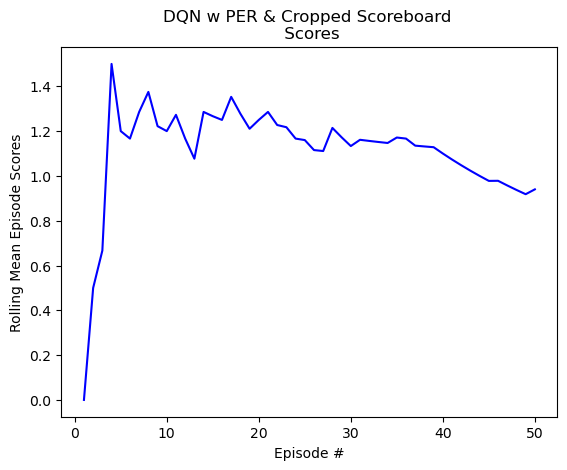

[SAVED PLOT] ./save_graph/run18/Run18_Bootstrapped_run17_stickyactions5percent_ep50_losses.png


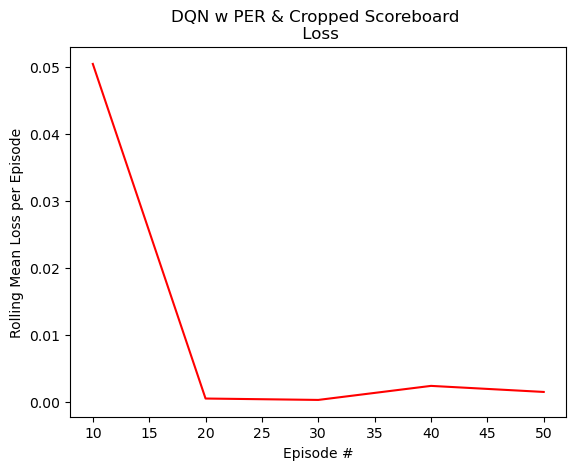

[SAVED PLOT] ./save_graph/run18/Run18_Bootstrapped_run17_stickyactions5percent_ep50_Qstats.png


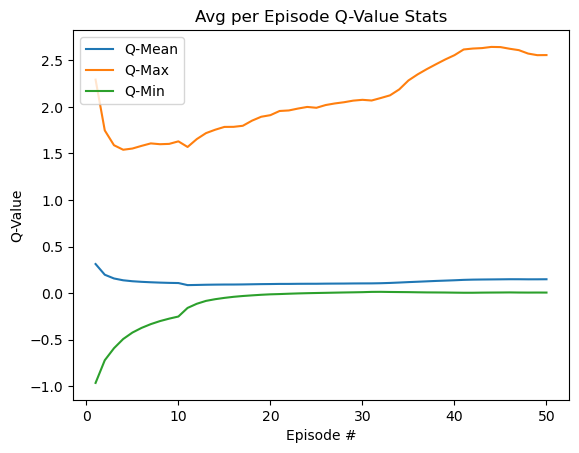

episode: 51   frame: 7817   score: 0.0   memory length: 211918   epsilon: 0.98515   steps: 120   lr: 0.0005   PER_beta: 0.40625 PER Alpha: 0.59375   reward MA: 0.94   mean loss: 0.00094   mean max Q: 2.3063
episode: 52   frame: 7966   score: 1.0   memory length: 212062   epsilon: 0.98486   steps: 149   lr: 0.0005   PER_beta: 0.40637 PER Alpha: 0.59363   reward MA: 0.94   mean loss: 0.00095   mean max Q: 2.59
[PER STATS] TD-error mean: 0.007618191525622922 std: 0.020115805744844915 min: 0.0 max: 1.530914306640625
episode: 53   frame: 8086   score: 0.0   memory length: 212177   epsilon: 0.98464   steps: 120   lr: 0.0005   PER_beta: 0.40647 PER Alpha: 0.59353   reward MA: 0.92   mean loss: 0.00085   mean max Q: 2.6369
episode: 54   frame: 8206   score: 0.0   memory length: 212292   epsilon: 0.98441   steps: 120   lr: 0.0005   PER_beta: 0.40656 PER Alpha: 0.59344   reward MA: 0.84   mean loss: 0.00067   mean max Q: 2.4658
episode: 55   frame: 8326   score: 0.0   memory length: 212407   eps

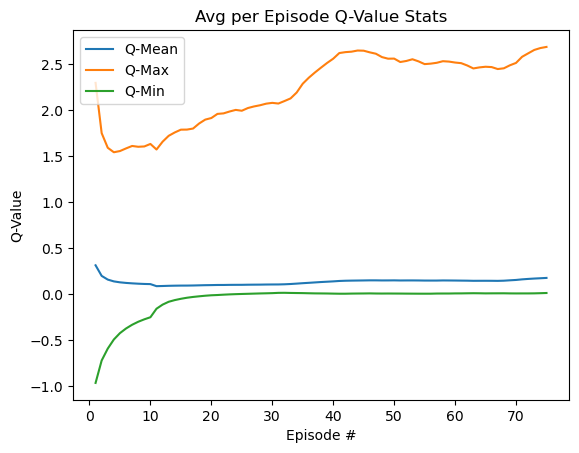

episode: 76   frame: 11314   score: 1.0   memory length: 215290   epsilon: 0.9785   steps: 148   lr: 0.0005   PER_beta: 0.40905 PER Alpha: 0.59095   reward MA: 0.64   mean loss: 0.00092   mean max Q: 2.8052
episode: 77   frame: 11556   score: 7.0   memory length: 215527   epsilon: 0.97804   steps: 242   lr: 0.0005   PER_beta: 0.40924 PER Alpha: 0.59076   reward MA: 0.76   mean loss: 0.00108   mean max Q: 2.7004
episode: 78   frame: 11676   score: 0.0   memory length: 215642   epsilon: 0.97782   steps: 120   lr: 0.0005   PER_beta: 0.40934 PER Alpha: 0.59066   reward MA: 0.68   mean loss: 0.0009   mean max Q: 2.6031
episode: 79   frame: 11796   score: 0.0   memory length: 215757   epsilon: 0.97759   steps: 120   lr: 0.0005   PER_beta: 0.40944 PER Alpha: 0.59056   reward MA: 0.68   mean loss: 0.00089   mean max Q: 2.7246
episode: 80   frame: 11991   score: 2.0   memory length: 215947   epsilon: 0.97722   steps: 195   lr: 0.0005   PER_beta: 0.40959 PER Alpha: 0.59041   reward MA: 0.72   me

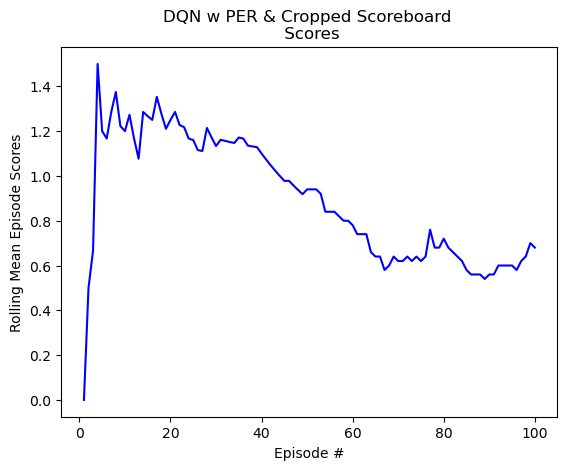

[SAVED PLOT] ./save_graph/run18/Run18_Bootstrapped_run17_stickyactions5percent_ep100_losses.png


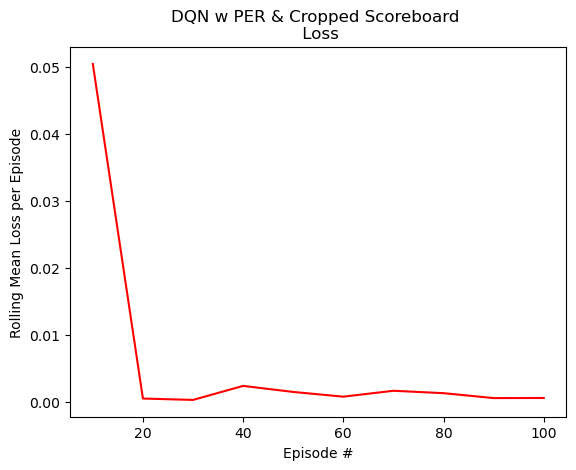

[SAVED PLOT] ./save_graph/run18/Run18_Bootstrapped_run17_stickyactions5percent_ep100_Qstats.png


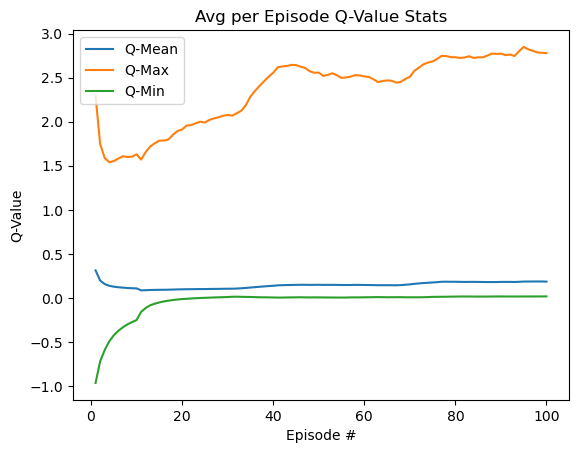

episode: 101   frame: 14906   score: 0.0   memory length: 218757   epsilon: 0.97168   steps: 120   lr: 0.0005   PER_beta: 0.41192 PER Alpha: 0.58808   reward MA: 0.68   mean loss: 0.00041   mean max Q: 2.7007
Target network updated at frame:  15000
[PER STATS] TD-error mean: 0.005469655105606217 std: 0.013210572655008527 min: 0.0 max: 0.9222412109375
episode: 102   frame: 15084   score: 2.0   memory length: 218930   epsilon: 0.97134   steps: 178   lr: 0.0005   PER_beta: 0.41207 PER Alpha: 0.58793   reward MA: 0.7   mean loss: 0.00028   mean max Q: 2.9872
episode: 103   frame: 15204   score: 0.0   memory length: 219045   epsilon: 0.97111   steps: 120   lr: 0.0005   PER_beta: 0.41216 PER Alpha: 0.58784   reward MA: 0.7   mean loss: 0.00261   mean max Q: 3.1633
episode: 104   frame: 15420   score: 2.0   memory length: 219256   epsilon: 0.9707   steps: 216   lr: 0.0005   PER_beta: 0.41234 PER Alpha: 0.58766   reward MA: 0.74   mean loss: 0.00266   mean max Q: 3.1181
episode: 105   frame: 1

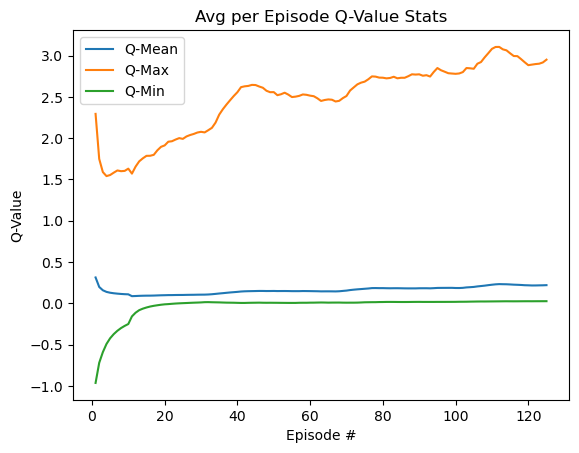

episode: 126   frame: 18859   score: 0.0   memory length: 222585   epsilon: 0.96417   steps: 120   lr: 0.0005   PER_beta: 0.41509 PER Alpha: 0.58491   reward MA: 0.88   mean loss: 0.00048   mean max Q: 2.9084
episode: 127   frame: 18979   score: 0.0   memory length: 222700   epsilon: 0.96394   steps: 120   lr: 0.0005   PER_beta: 0.41518 PER Alpha: 0.58482   reward MA: 0.74   mean loss: 0.00035   mean max Q: 2.9666
[PER STATS] TD-error mean: 0.0051602919751883355 std: 0.01362749382653329 min: 0.0 max: 1.349609375
episode: 128   frame: 19145   score: 1.0   memory length: 222861   epsilon: 0.96362   steps: 166   lr: 0.0005   PER_beta: 0.41532 PER Alpha: 0.58468   reward MA: 0.76   mean loss: 0.00037   mean max Q: 2.7315
episode: 129   frame: 19340   score: 2.0   memory length: 223051   epsilon: 0.96325   steps: 195   lr: 0.0005   PER_beta: 0.41547 PER Alpha: 0.58453   reward MA: 0.8   mean loss: 0.00024   mean max Q: 3.0148
episode: 130   frame: 19460   score: 0.0   memory length: 223166 

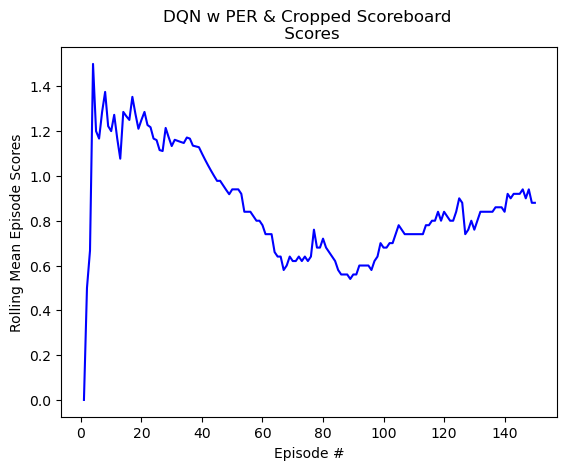

[SAVED PLOT] ./save_graph/run18/Run18_Bootstrapped_run17_stickyactions5percent_ep150_losses.png


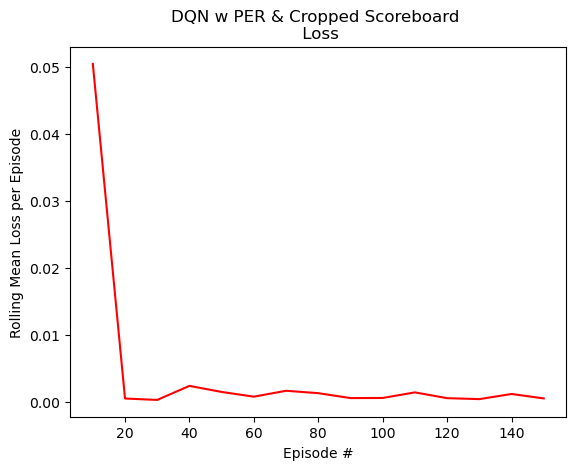

[SAVED PLOT] ./save_graph/run18/Run18_Bootstrapped_run17_stickyactions5percent_ep150_Qstats.png


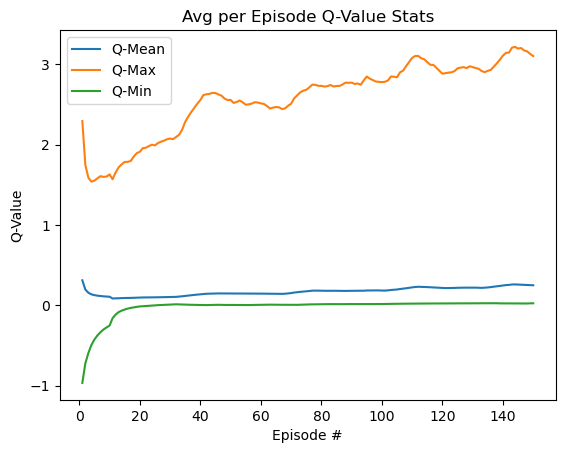

episode: 151   frame: 22702   score: 2.0   memory length: 226303   epsilon: 0.95687   steps: 215   lr: 0.0005   PER_beta: 0.41816 PER Alpha: 0.58184   reward MA: 0.92   mean loss: 0.0005   mean max Q: 3.1348
episode: 152   frame: 22850   score: 1.0   memory length: 226446   epsilon: 0.95659   steps: 148   lr: 0.0005   PER_beta: 0.41828 PER Alpha: 0.58172   reward MA: 0.9   mean loss: 0.00029   mean max Q: 2.9366
episode: 153   frame: 22970   score: 0.0   memory length: 226561   epsilon: 0.95636   steps: 120   lr: 0.0005   PER_beta: 0.41838 PER Alpha: 0.58162   reward MA: 0.9   mean loss: 0.00028   mean max Q: 3.1395
[PER STATS] TD-error mean: 0.005061420079452959 std: 0.013283728538719348 min: 0.0 max: 0.900390625
episode: 154   frame: 23138   score: 1.0   memory length: 226724   epsilon: 0.95604   steps: 168   lr: 0.0005   PER_beta: 0.41851 PER Alpha: 0.58149   reward MA: 0.88   mean loss: 0.00034   mean max Q: 3.2164
episode: 155   frame: 23258   score: 0.0   memory length: 226839   

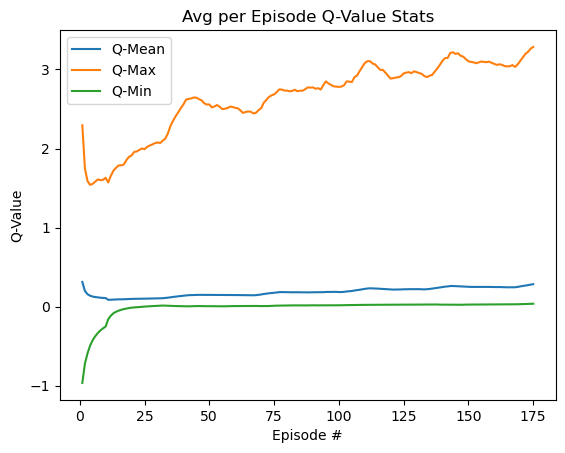

episode: 176   frame: 26215   score: 0.0   memory length: 229691   epsilon: 0.95019   steps: 120   lr: 0.0005   PER_beta: 0.42097 PER Alpha: 0.57903   reward MA: 0.76   mean loss: 0.0005   mean max Q: 3.1381
episode: 177   frame: 26441   score: 3.0   memory length: 229912   epsilon: 0.94976   steps: 226   lr: 0.0005   PER_beta: 0.42115 PER Alpha: 0.57885   reward MA: 0.82   mean loss: 0.00045   mean max Q: 3.2787
episode: 178   frame: 26561   score: 0.0   memory length: 230027   epsilon: 0.94953   steps: 120   lr: 0.0005   PER_beta: 0.42125 PER Alpha: 0.57875   reward MA: 0.8   mean loss: 0.0004   mean max Q: 3.4843
episode: 179   frame: 26681   score: 0.0   memory length: 230142   epsilon: 0.94931   steps: 120   lr: 0.0005   PER_beta: 0.42134 PER Alpha: 0.57866   reward MA: 0.76   mean loss: 0.00047   mean max Q: 3.0804
episode: 180   frame: 26875   score: 2.0   memory length: 230331   epsilon: 0.94894   steps: 194   lr: 0.0005   PER_beta: 0.4215 PER Alpha: 0.5785   reward MA: 0.8   m

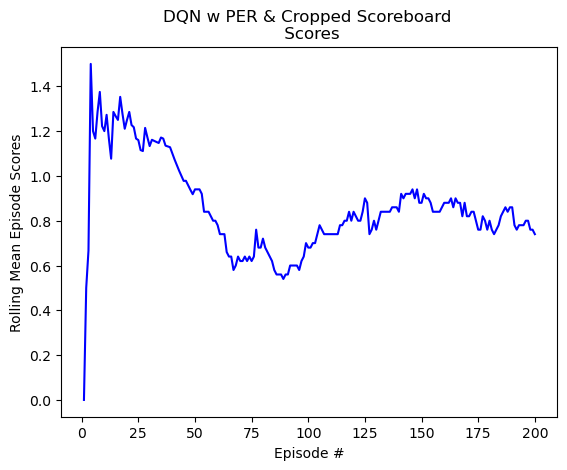

[SAVED PLOT] ./save_graph/run18/Run18_Bootstrapped_run17_stickyactions5percent_ep200_losses.png


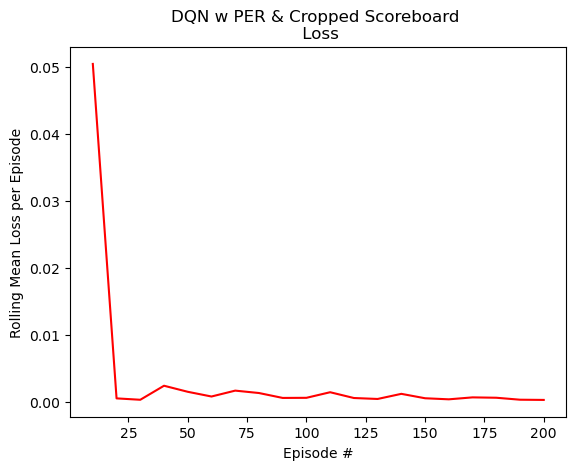

[SAVED PLOT] ./save_graph/run18/Run18_Bootstrapped_run17_stickyactions5percent_ep200_Qstats.png


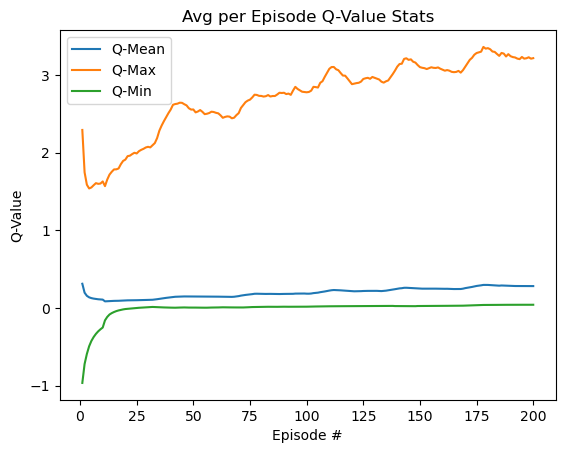

Target network updated at frame:  30000
[PER STATS] TD-error mean: 0.004514009694965516 std: 0.013423529647966446 min: 0.0 max: 0.9794921875
episode: 201   frame: 30087   score: 4.0   memory length: 233438   epsilon: 0.94283   steps: 255   lr: 0.0005   PER_beta: 0.42407 PER Alpha: 0.57593   reward MA: 0.78   mean loss: 0.00054   mean max Q: 3.4164
episode: 202   frame: 30235   score: 1.0   memory length: 233581   epsilon: 0.94255   steps: 148   lr: 0.0005   PER_beta: 0.42419 PER Alpha: 0.57581   reward MA: 0.78   mean loss: 0.00187   mean max Q: 3.504
episode: 203   frame: 30355   score: 0.0   memory length: 233696   epsilon: 0.94233   steps: 120   lr: 0.0005   PER_beta: 0.42428 PER Alpha: 0.57572   reward MA: 0.78   mean loss: 0.00236   mean max Q: 3.5064
episode: 204   frame: 30503   score: 1.0   memory length: 233839   epsilon: 0.94204   steps: 148   lr: 0.0005   PER_beta: 0.4244 PER Alpha: 0.5756   reward MA: 0.78   mean loss: 0.00129   mean max Q: 3.42
episode: 205   frame: 30623 

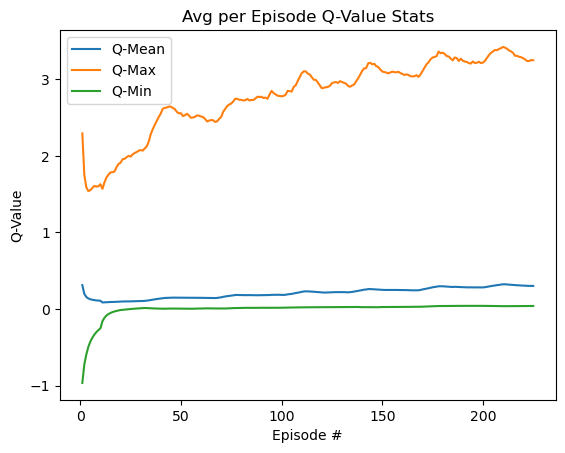

episode: 226   frame: 33641   score: 0.0   memory length: 236867   epsilon: 0.93608   steps: 120   lr: 0.0005   PER_beta: 0.42691 PER Alpha: 0.57309   reward MA: 0.78   mean loss: 0.00026   mean max Q: 3.243
episode: 227   frame: 33850   score: 3.0   memory length: 237071   epsilon: 0.93569   steps: 209   lr: 0.0005   PER_beta: 0.42708 PER Alpha: 0.57292   reward MA: 0.78   mean loss: 0.00038   mean max Q: 3.5108
[PER STATS] TD-error mean: 0.004752963845020705 std: 0.013251854484962758 min: 0.0 max: 0.8193359375
episode: 228   frame: 34029   score: 2.0   memory length: 237245   epsilon: 0.93534   steps: 179   lr: 0.0005   PER_beta: 0.42722 PER Alpha: 0.57278   reward MA: 0.82   mean loss: 0.00034   mean max Q: 3.4149
episode: 229   frame: 34177   score: 1.0   memory length: 237388   epsilon: 0.93506   steps: 148   lr: 0.0005   PER_beta: 0.42734 PER Alpha: 0.57266   reward MA: 0.84   mean loss: 0.0003   mean max Q: 3.3571
episode: 230   frame: 34297   score: 0.0   memory length: 237503 

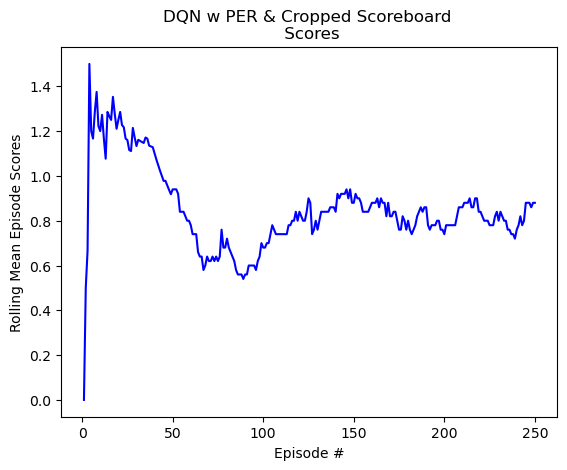

[SAVED PLOT] ./save_graph/run18/Run18_Bootstrapped_run17_stickyactions5percent_ep250_losses.png


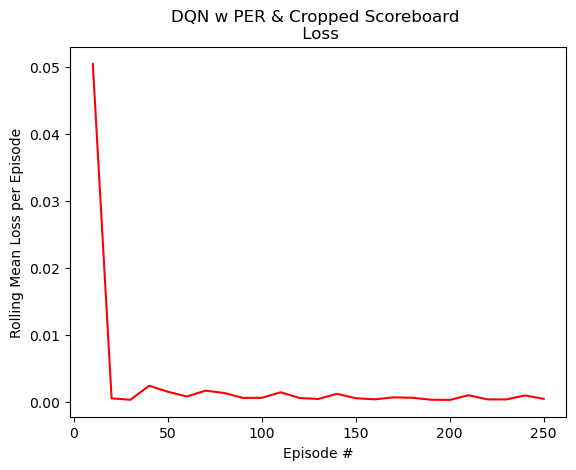

[SAVED PLOT] ./save_graph/run18/Run18_Bootstrapped_run17_stickyactions5percent_ep250_Qstats.png


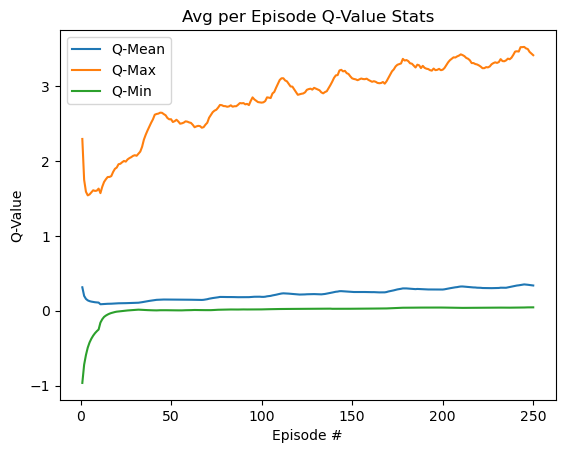

episode: 251   frame: 37476   score: 1.0   memory length: 240577   epsilon: 0.9288   steps: 148   lr: 0.0005   PER_beta: 0.42998 PER Alpha: 0.57002   reward MA: 0.82   mean loss: 0.00035   mean max Q: 3.4092
episode: 252   frame: 37654   score: 2.0   memory length: 240750   epsilon: 0.92846   steps: 178   lr: 0.0005   PER_beta: 0.43012 PER Alpha: 0.56988   reward MA: 0.84   mean loss: 0.00033   mean max Q: 3.4481
episode: 253   frame: 37863   score: 3.0   memory length: 240954   epsilon: 0.92806   steps: 209   lr: 0.0005   PER_beta: 0.43029 PER Alpha: 0.56971   reward MA: 0.9   mean loss: 0.00037   mean max Q: 3.6386
episode: 254   frame: 37983   score: 0.0   memory length: 241069   epsilon: 0.92783   steps: 120   lr: 0.0005   PER_beta: 0.43039 PER Alpha: 0.56961   reward MA: 0.88   mean loss: 0.00067   mean max Q: 3.4215
[PER STATS] TD-error mean: 0.005038485424256044 std: 0.014782805024679957 min: 0.0 max: 0.826171875
episode: 255   frame: 38103   score: 0.0   memory length: 241184  

In [ ]:
from config import *


set_seed(seed)
run_num = "18"
name = "Bootstrapped_run17_stickyactions5percent"
run_name = "Run"+ str(run_num) + "_" + name


from config import *
from gymnasium.wrappers import RecordVideo

# choose which Agent to use
from agent import Agent

#create fresh environment
env = gym.make('ALE/Breakout-v5', frameskip=4, repeat_action_probability=sticky_action_prob, full_action_space=False, render_mode='rgb_array')  # Use equivalent parameters to BreakoutDeterministic-v4

# setup video recording
def video_trigger(_):
    if len(episodes) == 0:
        return False
    else:
        curr_ep = episodes[-1]
        return (curr_ep > 99 and curr_ep % 100 == 0) 

video_path = f"./videos/run{run_num}"
if not os.path.exists(video_path):
    os.makedirs(video_path)
env = RecordVideo(env, video_folder=video_path, episode_trigger=video_trigger)


print(f"Starting run {run_name}")
train_interval = 1
    
evaluation_reward = deque(maxlen=evaluation_reward_length)
rewards, episodes = [], []
reward = 0
best_eval_reward = curr_mean_reward = last_save_reward = 0

#initialize trackers
## LOSS TRACKERS ##
losses_window = deque(maxlen=10)
loss_history = []
episode_losses = []
loss = mean_loss = 0

# ## Q-VALUE TRACKERS ##
episode_q_means = []
episode_q_maxs = []
episode_q_mins = []
q_mean_window = deque(maxlen=10)
q_max_window = deque(maxlen=10)
q_min_window = deque(maxlen=10)
q_stats_history = {
    'mean': [],
    'max': [],
    'min': [],
    'episode': []
}

# Epsilon Bump Control Variables
plateau_patience = 300
episodes_since_improvement = 0
epsilon_bump = 0.15  # amount to re-increase epsilon
soonest_bump = 2000  # earliest episode to apply epsilon bump

frame = 0
ep_start = 0
training_started_flg = False

print("Instantiating agent")

#Bootstrapped loading run 17
mem_path = './checkpoints/Run17_StdDQN_750Kfr_newest_get_frame_CirularPER_wIS_159356_replay_buffer.pkl'
checkpoint = torch.load('./checkpoints/Run17_StdDQN_750Kfr_newest_get_frame_CirularPER_wIS_2000_checkpoint.pt')
agent = Agent(action_size, mem_path)  #use when starting with prefilled replay buffer
agent.capacity = Memory_capacity  #reset memory capacity
assert sum(agent.memory.valid_flags) == len(agent.memory.valid_indices) == len(agent.memory.td_errors)

td_errors_np = np.array(agent.memory.td_errors, dtype=np.float32)

# Print stats before
num_invalid = np.sum(~np.isfinite(td_errors_np)) + np.sum(td_errors_np <= 0)
print(f"[SANITIZER] Fixing {num_invalid} invalid or nonpositive TD-errors...")

# Fix all issues
td_errors_np = np.where(~np.isfinite(td_errors_np) | (td_errors_np <= 0), 1.0, td_errors_np)

# Convert back to list
agent.memory.td_errors = td_errors_np.tolist()
# assert np.all(np.array(agent.memory.td_errors) >= 0), "TD-errors contain negatives"
agent.policy_net.load_state_dict(checkpoint['policy_net'])
# agent.target_net.load_state_dict(checkpoint['target_net'])
agent.beta = IS_BETA
agent.alpha = PER_ALPHA

# agent = Agent(action_size, mem_path)  
# agent = Agent(action_size)

#########################
#### LOAD CHECKPOINT ####
# metadata = agent.load_checkpoint("Run8_Stdized_DDQN_750K_frames", 2999)  #Edit episode number
# frame = metadata['global_frame']
# agent.load_replay_buffer("Run8_Stdized_DDQN_750K_frames", 711354)
# ep_start = metadata['global_episode']
# evaluation_reward = metadata['eval_rewards']
# rewards = metadata['rewards']    
# episodes = metadata['episodes']
# losses_window = metadata['last_10_ep_losses']
# loss_history = metadata['loss_tracker']
# training_started_flg = True
########################


start_train_immediate = True
frame_max = TRAINING_STEPS
e = ep_start

while e < EPISODES:
    #limit number of frames for consistent testing
    if frame >= frame_max:
        break

    done = False
    score = 0
    episode_losses = []
    history = np.zeros([5, 84, 84], dtype=np.uint8)
    step = 0
    state, _ = env.reset()
    next_state = state
    life = number_lives
    fire_ready = True
    no_reward_steps = 0

    get_init_state(history, state, HISTORY_SIZE)

    while not done:
        
        #limit number of frames for consitent testing
        if frame >= frame_max:
            break

        step += 1
        frame += 1

        # Selet Action (with robust check for FIRE action)
        if fire_ready:  
            next_state, force_done = reset_after_life_loss(env, history)
            if force_done:
                break
            action = 1
            fire_ready = False
        else:
            trainable_action = agent.get_action(np.float32(history[:4, :, :]) / 255.)
            action = TRAINABLE_ACTIONS[trainable_action]

        # Step the environment
        state = next_state
        next_state, reward, terminations, truncations, info = env.step(action)  
        done = truncations or terminations
        
        # Failsafe to force reset if no reward for 3000 steps (prevents agent from getting stuck)
        stuck_limit = 3000
        if no_reward_steps > stuck_limit:
            done = True
            print(f"[WARNING] No reward for {stuck_limit} steps, forcing reset | ", "Episode:", e, "  Frame:", frame, ) 
             
        frame_next_state = get_frame(next_state)
             
        # append next state to history
        history[4, :, :] = frame_next_state
        
        # life handling
        lost_life = check_live(life, info['lives'])  #check if the agent has lost a life
        if lost_life:
            fire_ready = True
        life = info['lives']
        
        r = reward
        if r == 0:
            no_reward_steps += 1
        else:
            no_reward_steps = 0 

        # Store the transition in replay buffer if it was not a FIRE action
        
        if action in TRAINABLE_ACTIONS:
            trainable_index = TRAINABLE_ACTIONS.index(action)
            term_state = done or lost_life
            if type(agent.memory).__name__ == "CircularReplayMemoryPER":
                # print("[DEBUG] Using CircularReplayMemoeryPER.push()")
                # agent.memory.push(agent, deepcopy(frame_next_state), trainable_index, r, term_state)  # for use when model is used to estimate new TD-errors
                mean_td = np.mean(agent.recent_td_errors) if len(agent.recent_td_errors) > 0 else 1.0
                agent.memory.push(deepcopy(frame_next_state), trainable_index, r, term_state, mean_recent_td_error=mean_td)
            else:
                agent.memory.push(deepcopy(frame_next_state), trainable_index, r, term_state)
        
        # Start training after random sample generation
        if training_started_flg == False and (frame == train_frame or (start_train_immediate and frame == 1)):
            print("Starting training")
            training_started_flg = True
            e = ep_start  #reset episode counter when training starts
        if(training_started_flg): 
            if frame % train_interval == 0: # Use adaptive training interval
                loss, q_stats = agent.train_policy_net()
                episode_losses.append(loss)
                episode_q_means.append(q_stats['q_mean'])
                episode_q_maxs.append(q_stats['q_max'])
                episode_q_mins.append(q_stats['q_min'])
            # Update the target network
            if (frame % (train_interval * update_target_network_frequency)) == 0:
                agent.update_target_net()
                print("Target network updated at frame: ", frame)
        
        # Update score and history
        score += reward
        history[:4, :, :] = history[1:, :, :]  # shift history by one erasing oldest frame

        ## DEBUG ##
        if frame % 1000 == 0 and len(agent.memory.td_errors) > 0:
            agent.memory.log_td_error_distribution()
            
        if done:
            e += 1
            fire_ready = True
            evaluation_reward.append(score)            
            

            # print episode information every X episodes
            if e % 1 == 0:
                print("episode:", e, "  frame:", frame, "  score:", score, "  memory length:",
                  len(agent.memory), "  epsilon:", round(agent.epsilon, 5), 
                  "  steps:", step, "  lr:", agent.optimizer.param_groups[0]['lr'], "  PER_beta:", round(agent.beta,5), "PER Alpha:", round(agent.alpha,5),
                  "  reward MA:", round(np.mean(evaluation_reward), 3), 
                  "  mean loss:", round(mean_loss, 5), "  mean max Q:", round(np.mean(episode_q_maxs), 4))
                #   "  latest step Q max:", round(q_stats['q_max'], 4))


            
            if training_started_flg:



                episodes.append(e)
                rewards.append(np.mean(evaluation_reward))  # record moving average of last evaluation_reward_length episodes

                # # adapt training interval to agent performance
                # if np.mean(evaluation_reward) < 8:
                #     train_interval = 4
                # elif np.mean(evaluation_reward) < 15:
                #     train_interval = 2
                # else:
                #     train_interval = 1

                ## DEBUG ##
                # Check TD-error distribution in Replay Buffer
                if e>0 and e % 100 == 0:
                    agent.memory.log_td_error_distribution()

                # save rolling loss everages every X episodes
                if episode_losses:
                    mean_loss = sum(episode_losses) / len(episode_losses)
                    losses_window.append(mean_loss)
                    if e > 9 and e % 10 == 0:
                        loss_history.append((np.mean(losses_window), e))

                # save rolling Q-score stat averages
                q_mean_window.append(np.mean(episode_q_means))
                q_max_window.append(np.mean(episode_q_maxs))
                q_min_window.append(np.mean(episode_q_mins))
                q_stats_history['mean'].append(np.mean(q_mean_window))
                q_stats_history['max'].append(np.mean(q_max_window))
                q_stats_history['min'].append(np.mean(q_min_window))
                q_stats_history['episode'].append(e)
                episode_q_means = []
                episode_q_maxs = []
                episode_q_mins = []

                # plot the rewards every X episodes
                if e > 0 and e % 50 == 0:
                    # clear_output(wait=True)
                    pylab.plot(episodes, rewards, 'b')
                    pylab.xlabel('Episode #')
                    pylab.ylabel('Rolling Mean Episode Scores') 
                    pylab.title('DQN w PER & Cropped Scoreboard \n Scores')
                    plot_path = f"./save_graph/run{run_num}/{run_name}_ep{e}_scores.png"
                    os.makedirs(os.path.dirname(plot_path), exist_ok=True)
                    pylab.savefig(plot_path)
                    print(f"[SAVED PLOT] {plot_path}")
                    pylab.show()
                    pylab.close()
                
                # every X episodes, plot the mean losses
                if e > 0 and e % 50 == 0:
                    x = [entry[1] for entry in loss_history]
                    y = [entry[0] for entry in loss_history]
                    pylab.plot(x, y, 'r')
                    pylab.xlabel('Episode #')
                    pylab.ylabel('Rolling Mean Loss per Episode') 
                    pylab.title('DQN w PER & Cropped Scoreboard \n Loss')
                    plot_path = f"./save_graph/run{run_num}/{run_name}_ep{e}_losses.png"
                    os.makedirs(os.path.dirname(plot_path), exist_ok=True)
                    pylab.savefig(plot_path)
                    print(f"[SAVED PLOT] {plot_path}")
                    pylab.show()
                    pylab.close()

                # plot Q-value statistics every X episodes
                if e > 0 and e % 25 == 0:
                    pylab.plot(q_stats_history['episode'], q_stats_history['mean'], label='Q-Mean')
                    pylab.plot(q_stats_history['episode'], q_stats_history['max'], label='Q-Max')
                    pylab.plot(q_stats_history['episode'], q_stats_history['min'], label='Q-Min')
                    pylab.xlabel('Episode #')
                    pylab.ylabel('Q-Value')
                    pylab.title('Avg per Episode Q-Value Stats')
                    pylab.legend(loc='upper left')
                    plot_path = f"./save_graph/run{run_num}/{run_name}_ep{e}_Qstats.png"
                    os.makedirs(os.path.dirname(plot_path), exist_ok=True)
                    pylab.savefig(plot_path)
                    print(f"[SAVED PLOT] {plot_path}")
                    pylab.show()
                    pylab.close()


                    ## DEBUG ##
                    # print(f"[PLOT DEBUG] Last 5 q_means: {q_stats_history['mean'][-5:]}")

                # Checkpoint the training process every X episodes 
                if e > 0 and e % 1000 == 0:
                    metadata = create_metadata(agent, e, frame, evaluation_reward, rewards, episodes, losses_window, loss_history, q_stats_history, q_mean_window, \
                                               q_max_window, q_min_window, agent.epsilon, alpha=agent.alpha, beta=agent.beta)
                    agent.save_checkpoint(metadata, run_name, e)
                if e > 0 and e % 1000 == 0:
                    agent.save_replay_buffer(run_name, frame)

                # Check if reward has improved
                curr_mean_reward = np.mean(evaluation_reward)
                if curr_mean_reward > best_eval_reward:
                    best_eval_reward = curr_mean_reward
                    episodes_since_improvement = 0
                else:
                    episodes_since_improvement += 1
                
                # save model if it is good
                if curr_mean_reward > 8 and curr_mean_reward > (1.05 * last_save_reward):
                    model_path = f"./save_model/run{run_num}/good_{run_name}_{e}_eps.pth"
                    os.makedirs(os.path.dirname(model_path), exist_ok=True)
                    torch.save(agent.policy_net.state_dict(), model_path)
                    print(f"[SAVED MODEL] {model_path}")
                    last_save_reward = curr_mean_reward
               
                # # # Apply epsilon bump if plateauing
                # if e > soonest_bump and episodes_since_improvement >= plateau_patience:
                #     if agent.epsilon < agent.epsilon_max:
                #         agent.epsilon = min(agent.epsilon + epsilon_bump, agent.epsilon_max)
                #         print(f"[BUMP] Epsilon bumped to {agent.epsilon:.4f} after {plateau_patience} stagnant episodes.")
                #     episodes_since_improvement = 0  # Reset counter after bump



# Checkpoint the model at the end of training loop
metadata = create_metadata(agent, e, frame, evaluation_reward, rewards, episodes, losses_window, loss_history, q_stats_history, q_mean_window, \
                            q_max_window, q_min_window, agent.epsilon, alpha=agent.alpha, beta=agent.beta)
agent.save_checkpoint(metadata, run_name, e)
agent.save_replay_buffer(run_name, frame)

print("Training complete")



In [ ]:
# End logging
sys.stdout = tee.ipython_stdout
tee.close()

In [ ]:

# === Load checkpoint files ===
ddqn_ckpt = torch.load("./checkpoints/Run12_DDQN_750K_frames_imprvdBatching_3007_checkpoint.pt")
dqn_ckpt  = torch.load("./checkpoints/Run13_StdDQN_750K_frames_imprvdBatching_2673_checkpoint.pt")

# === Extract metadata ===
ddqn_meta = ddqn_ckpt["metadata"]
dqn_meta = dqn_ckpt["metadata"]

# # === Extract episode indices and rolling mean rewards ===
# ddqn_episodes = ddqn_meta["episodes"]
# ddqn_rewards = ddqn_meta["rewards"]

# dqn_episodes = dqn_meta["episodes"]
# dqn_rewards = dqn_meta["rewards"]

# # === Plot ===
# plt.figure(figsize=(10, 6))
# plt.plot(dqn_episodes, dqn_rewards, label="DQN", color="red")
# plt.plot(ddqn_episodes, ddqn_rewards, label="DDQN", color="blue")
# plt.xlabel("Episode #", fontweight="bold")
# plt.ylabel("Mean Episode Score (Moving Avg)", fontweight="bold")
# plt.legend(loc = "upper left")
# # Main title
# pylab.text(0.5, 1.05, 'Std DQN vs DDQN Scores',
#            ha='center', va='bottom', transform=pylab.gca().transAxes,
#            fontsize=14, fontweight='semibold')

# # Subtitle (smaller font)
# pylab.text(0.5, 1.01, '(750K training steps)',
#            ha='center', va='bottom', transform=pylab.gca().transAxes,
#            fontsize=10, color='gray')


# plot_path = f"./presentation_assets/DQN_vs_DDQN_750K_steps_SCORES.png"
# os.makedirs(os.path.dirname(plot_path), exist_ok=True)
# pylab.savefig(plot_path, bbox_inches='tight')
# print(f"[SAVED PLOT] {plot_path}")
# plt.show()


# # === Extract loss data ===
ddqn_loss_history = ddqn_meta["loss_tracker"]
dqn_loss_history = dqn_meta["loss_tracker"]

ddqn_episodes = [entry[1] for entry in ddqn_loss_history]
ddqn_losses = [entry[0] for entry in ddqn_loss_history]

dqn_episodes = [entry[1] for entry in dqn_loss_history]
dqn_losses = [entry[0] for entry in dqn_loss_history]

# === Plot ===
plt.figure(figsize=(10, 6))
plt.plot(dqn_episodes, dqn_losses, label="DQN", color="red")
plt.plot(ddqn_episodes, ddqn_losses, label="DDQN", color="blue")
plt.xlabel("Episode #", fontweight="bold")
plt.ylabel("Mean Episode Loss (Moving Avg)", fontweight="bold")
plt.legend(loc = "best")
# Main title
pylab.text(0.5, 1.05, 'Std DQN vs DDQN Huber Loss',
           ha='center', va='bottom', transform=pylab.gca().transAxes,
           fontsize=14, fontweight='semibold')

# Subtitle (smaller font)
pylab.text(0.5, 1.01, '(750K training steps)',
           ha='center', va='bottom', transform=pylab.gca().transAxes,
           fontsize=10, color='gray')


plot_path = f"./presentation_assets/DQN_vs_DDQN_750K_steps_LOSSES.png"
os.makedirs(os.path.dirname(plot_path), exist_ok=True)
pylab.savefig(plot_path, bbox_inches='tight')
print(f"[SAVED PLOT] {plot_path}")
plt.show()


In [ ]:
# chkpt = torch.load("./checkpoints/Run12_DDQN_750K_frames_imprvdBatching_3007_checkpoint.pt")
from model import DQN_DualBranch
action_size = len(TRAINABLE_ACTIONS)
model = DQN_DualBranch(action_size)
model.eval()

#create dummy input for model
dummy_input = torch.rand(BATCH_SIZE, 6, 84, 84)

#export to ONNX
torch.onnx.export(model, dummy_input, "Branched Network.onnx",
                  input_names=["input"], output_names=["output"],
                  dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}},
                  opset_version=11)

print("ONNX model exported successfully!")


## Timediff Frames

Instead of using a 4 frame history to train the model, here we will feed the model the 4 frames plus the "diff" between each of the 4 frames to help isolate the ball position which is the most important thing for the model to learn

# Visualize Agent Performance

BE AWARE THIS CODE BELOW MAY CRASH THE KERNEL IF YOU RUN THE SAME CELL TWICE.

Please save your model before running this portion of the code.

### Play Game in Window or Save Video

In [ ]:
import gymnasium as gym
from gymnasium.wrappers import RecordVideo

# set random seed to sync visual and recorded game
seed = 55
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)

# Load and setup Agent
print("Instantiating agent")
agent = Agent(action_size)
agent.load_policy_net("./save_model/run3/good_Run3_DDQN_Serial_InvTimeEpsilon_ddqn_886_eps.pth")
agent.policy_net.eval()
agent.epsilon = 0  # Set agent to only exploit the best action


# Create environments
env_human = gym.make('ALE/Breakout-v5', frameskip=4, repeat_action_probability=sticky_action_prob, full_action_space=False, render_mode="human")
# env_record = RecordVideo(env_record, video_folder="./videos", episode_trigger=lambda e: True)

# Reset to seed
state_h, _ = env_human.reset(seed=seed)
state_h = do_random_actions(env_human, 20)


# Setup History
history = np.zeros([HISTORY_SIZE + 1, 84, 84], dtype=np.uint8)
get_init_state(history, state_h, HISTORY_SIZE)

done = False
fire_ready = True
life = number_lives
score = 0
step = 0

while not done:
    step += 1

    # Select action
    if fire_ready:
        print(f"[DEBUG] Agent is not acting — sending FIRE at step {step}")
        action = 1
        fire_ready = False
    else:
        model_action = agent.get_action(np.float32(history[:4, :, :]) / 255.)
        action = TRAINABLE_ACTIONS[model_action]

    # Step the environment
    state_h, reward, term_h, trunc_h, info = env_human.step(action)
    done = term_h or trunc_h

    # update history
    frame_next_state = get_frame(state_h)
    history[4, :, :] = frame_next_state
    history[:4, :, :] = history[1:, :, :]  #shift history by one erasing oldest frame
    
    # check if life has been lost
    lost_life = check_live(life, info['lives'])  #check if the agent has lost a life
    if lost_life:
        print(f"[DEBUG] Lost life detected at step {step}")
        fire_ready = True
    life = info['lives']
    
    # keep track of score
    score += reward # update total score

    
env_human.close()


### Play Game Rendered in Jupyter Notebook

In [ ]:
from IPython.display import display as ipythondisplay, clear_output

def show_state_live(frame, step=0, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(frame)
    plt.title(f"Step: {step} {info}")
    plt.axis('off')
    clear_output(wait=True)
    ipythondisplay(plt.gcf())

In [ ]:
import gymnasium as gym
from gymnasium.wrappers import RecordVideo


# set random seed to sync visual and recorded game
seed = 42
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)

# Load and setup Agent
# Choose whether to use double DQN
double_dqn = False # set to True if using double DQN agent
if double_dqn:
    from agent_double import Agent
else:
    from agent import Agent

#Initialize agent
print("Instantiating agent")
agent = Agent(action_size)
agent.load_policy_net("./save_model/Run1_serial/good_breakout_dqn_1256_eps.pth")
agent.policy_net.eval()
agent.epsilon = 0  # Set agent to only exploit the best action


# Create environments
env = gym.make('ALE/Breakout-v5', frameskip=4, repeat_action_probability=sticky_action_prob, full_action_space=False, render_mode="rgb_array")
# Use RecordVideo to save the video to the "videos" directory
# env = RecordVideo(env, video_folder="./videos", episode_trigger=lambda episode_id: True)

# Reset the environment
state, _ = env.reset(seed=seed)

# Setup History
history = np.zeros([HISTORY_SIZE + 1, 84, 84], dtype=np.uint8)
get_init_state(history, state, HISTORY_SIZE)

#Initialize variables
step = 0
done = False
fire_ready = True
life = number_lives
score = 0

while not done:

    # Render the current frame live in the notebook
    show_state_live(state, step)   

    # Select action
    if fire_ready:
        action = 1
        fire_ready = False
    else:
        model_action = agent.get_action(np.float32(history[:4, :, :]) / 255.)
        action = TRAINABLE_ACTIONS[model_action]

    # Step the environment
    next_state, reward, term, trunc, info = env.step(action)
    done = term or trunc

    # update history
    frame_next_state = get_frame(state)
    history[4, :, :] = frame_next_state
    history[:4, :, :] = history[1:, :, :]  #shift history by one erasing oldest frame
    
    # check if life has been lost
    lost_life = check_live(life, info['lives'])  #check if the agent has lost a life
    if lost_life:
        fire_ready = True  
        # do_random_actions(env_human, 30) #IMPT: introduce randomness to game and paddle position before next life
    life = info['lives']
    
    # keep track of score
    score += reward # update total score

    state = next_state
    step += 1

    

env.close()

## Model Comparison Tester

In [ ]:
from utils import *
from config import *
import gymnasium as gym



# Load and setup Agent
# Choose which agent class to load
from agent import Agent
# from agent_timediff import Agent

# 50 unique, fixed seeds
seeds = [765,817,53,705,990,511,236,661,654,418,804,968,1,749,125,293,985,574, 
         447,948,687,317,280,645,927,842,309,616,717,930,778,323,595,798,195,11,
         483,316,690,951,196,307,906,558,516,844,410,965,371,886]


#Initialize agent
print("Instantiating agent")
agent = Agent(action_size)
# agent.load_policy_net("./save_model/run12/good_Run12_DDQN_750K_frames_imprvdBatching_2319_eps.pth")
agent.load_policy_net("./save_model/run13/good_Run13_StdDQN_750K_frames_imprvdBatching_2477_eps.pth")
# agent.load_policy_net("./save_model/run14/good_Run14_StdDQN_750Kfr_timediff_new_get_frame_2425_eps.pth")
agent.target_net.load_state_dict(agent.policy_net.state_dict())
agent.target_net.eval()
agent.policy_net.eval()
agent.epsilon = 0.05  # Set agent to use model action 95% of the time for robustness


# Create environments
env = gym.make('ALE/Breakout-v5', frameskip=4, repeat_action_probability=0.0, full_action_space=False, render_mode="rgb_array")
# Use RecordVideo to save the video to the "videos" directory
# video_path = f"./videos/testing/run13"
# if not os.path.exists(video_path):
#     os.makedirs(video_path)
# env = RecordVideo(env, video_folder=video_path, episode_trigger=lambda e: True)


scores = []

for e, seed in enumerate(seeds):
    set_seed(seed)
    # Reset the environment
    state, _ = env.reset(seed=seed)

    # Setup History
    history = np.zeros([HISTORY_SIZE + 1, 84, 84], dtype=np.uint8)
    get_init_state(history, state, HISTORY_SIZE)  #non cropped version
    # new_get_init_state(history, state, HISTORY_SIZE)  #cropped version

    #Initialize variables
    step = 0
    done = False
    fire_ready = True
    life = number_lives
    score = 0

    while not done:
        
        # Selet Action (with robust check for FIRE action)
        if fire_ready:
            next_state, force_done = reset_after_life_loss(env, history)
            if force_done:
                break
            action = 1
            fire_ready = False
        else:
            trainable_action = agent.get_action(np.float32(history[:4, :, :]) / 255.)
            action = TRAINABLE_ACTIONS[trainable_action]

        # Step the environment
    
        next_state, reward, term, trunc, info = env.step(action)
        done = term or trunc
        # update total score
        score += reward 

        # update history
        history[4, :, :] = get_frame(next_state)  #non cropped version
        # history[4, :, :] = new_get_frame(next_state)  #cropped version
        history[:4, :, :] = history[1:, :, :]  #shift history by one erasing oldest frame
        
        # check if life has been lost
        lost_life = check_live(life, info['lives'])  #check if the agent has lost a life
        if lost_life:
            fire_ready = True  
        life = info['lives']
        
        
        step += 1
    
    print("episode:", e, "  seed:", seed, "  score:", score, "  epsilon:", round(agent.epsilon, 5), 
    "  steps:", step)
    
    scores.append(score)

env.close()
print("Mean Score: ", np.mean(scores))
print("Std Score: ", np.std(scores))
print("Max Score: ", np.max(scores))
print("Min Score: ", np.min(scores))
print("Median Score: ", np.median(scores))

env.close()

## SCRATCH

In [ ]:
for i in range(4):
    print(i)


In [ ]:
env = gym.make('ALE/Breakout-v5', frameskip=4, repeat_action_probability=0.0, full_action_space=False)
env.reset()
next_state, reward, terminations, truncations, info = env.step(torch.tensor([[1]]))
done = truncations or terminations
print("reward: ", reward)
print("done: ", done)
print("info: ", info)
print(next_state.shape)

In [ ]:
print(env.action_space)
print("Expected type:", type(env.action_space.sample()))

In [ ]:
print("agent memory type: ", type(agent.memory.memory[0]))
print("agent memory[0]: ", agent.memory.memory[0])

In [ ]:
print(type(agent.memory))

### Debug Harnesses

In [ ]:
import numpy as np
import random
import memory as mem

# Use a small capacity for easy debugging
capacity = 10
history_size = 3
memory = mem.CircularReplayMemoryPER(capacity, history_size)

# Push 30 fake transitions (will cause multiple wraps)
for step in range(30):
    frame = np.ones((84, 84), dtype=np.uint8) * step
    action = random.randint(0, 3)
    reward = random.random()
    done = (step % 7 == 0)  # Random done flag every few steps

    memory.push(frame, action, reward, done)

    num_flags = sum(memory.valid_flags)
    num_indices = len(memory.valid_indices)

    if num_flags != num_indices:
        print(f"❌ Mismatch at step {step}:")
        print(f"   valid_flags count = {num_flags}")
        print(f"   valid_indices count = {num_indices}")
        print(f"   position = {memory.position}")
        print(f"   size = {memory.size}")
        print(f"   flags: {memory.valid_flags}")
        print(f"   valid_indices: {memory.valid_indices}")
        raise AssertionError("valid_flags and valid_indices out of sync")

print("✅ All checks passed — valid_flags == valid_indices through all pushes.")


In [ ]:
import memory as RepBuff
import traceback

# Configuration
capacity = 1000
history_size = 4
batch_size = 32


# Configuration
capacity = 1000
history_size = 4
batch_size = 16
alpha = 0.6

# Initialize memory
memory = RepBuff.CircularReplayMemoryPER(capacity=capacity, history_size=history_size)

# Track previous cache values for comparison
previous_probs = None

# Simulate a bunch of pushes
for step in range(1500):
    print(f"Step {step}, ")
    frame = np.ones((84, 84), dtype=np.uint8) * step
    action = random.randint(0, 3)
    reward = random.random()
    done = (step % 50 == 0)


    memory.push(frame, action, reward, done)

    # Occasionally update TD-errors
    if step > 100 and len(memory.valid_indices) >= batch_size:
        indices = random.sample(range(len(memory.valid_indices)), min(len(memory.valid_indices), batch_size))
        print(len(indices))
        new_td = np.random.rand(batch_size).astype(np.float32)
        memory.update_td_errors(indices, new_td)

    # Check probability stability and cache correctness
    if len(memory.valid_indices) >= batch_size:
        try:
            # Trigger cache update and record internal state
            probs = memory.get_sampling_probs(memory.valid_indices)
            total_prob = probs.sum()

            # Cache sanity checks
            assert hasattr(memory, "_cached_probs"), "Missing cached_probs"
            assert memory._cached_probs is not None, "Cached probs not populated"
            assert np.allclose(memory._cached_probs.sum(), 1.0, atol=1e-4), "Cached probs do not sum to 1"

            # Compare with previous cache state
            if previous_probs is not None:
                if np.array_equal(previous_probs, memory._cached_probs):
                    print(f"[DEBUG] Cache unchanged at step {step} — may be okay if no new TDs pushed")
                else:
                    print(f"[DEBUG] Cache updated at step {step}")
            previous_probs = memory._cached_probs.copy()

            if np.isnan(total_prob) or total_prob == 0:
                print("[ERROR] Total probability is invalid at step:", step)
                print("TD errors:", [memory.td_errors[i] for i in memory.valid_indices[:10]])
                print("Sampling probs:", probs[:10])
                raise AssertionError("Invalid sampling distribution")

        except Exception as e:
            print("[EXCEPTION]", str(e))
            traceback.print_exc()
            break

print("✅ Debug harness completed without total_priority = 0 and with valid cache behavior")
